In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip3 install pycaret[full]
!pip3 install pandas-profiling
!pip3 install swifter
!pip3 install pyarrow
!pip3 install shap

     |████████████████████████████████| 266 kB 2.3 MB/s 
     |████████████████████████████████| 167 kB 54.2 MB/s 
     |████████████████████████████████| 14.6 MB 181 kB/s 
     |████████████████████████████████| 111 kB 78.3 MB/s 
     |████████████████████████████████| 1.7 MB 62.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 2.0 MB 69.5 MB/s 
     |████████████████████████████████| 80 kB 9.2 MB/s 
     |████████████████████████████████| 261 kB 55.8 MB/s 
     |████████████████████████████████| 1.3 MB 57.6 MB/s 
     |████████████████████████████████| 271 kB 55.6 MB/s 
     |████████████████████████████████| 6.8 MB 43.9 MB/s 
     |████████████████████████████████| 356 kB 77.7 MB/s 
     |████████████████████████████████| 166.7 MB 8.4 kB/s 
     |█████████████████

     |████████████████████████████████| 123 kB 2.2 MB/s 


In [2]:
# We will be using nltk resources for natural language programming
# Need to download the following knowledge texts
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
import os
import swifter
import pandas as pd
import numpy as np
from pathlib import Path

# Setup data path
data_path = Path('/content/drive/My Drive/pcml_data/6USML')
model_path = Path('/content/drive/My Drive/pcml_data/6USML/models')

### Use-case #1: Classifying emotions from text

You are given a dataset of tweets, with each entry tagged to a sentiment. You are tasked to train a ML model that can predict the sentiment of each tweet.

Note that this sentiment is not simply positive or negative. A positive and negative outcome (1, 0) in sentiment analysis can be done fairly easily with Naive Bayesian Classification.

To make matters more complex, we are dealing with tweets that do not observe proper reporting like news or wikipedia entries. In fact, tweets reflect a certain colloquial style that can change with time.

This is a compound problem that tests your ability to work using both unsupervised and supervised machine learning.

In [6]:
# Read dataset
dataset = pd.read_csv(data_path / 'text_emotion.csv')

emotion = dataset['sentiment']
tweets = dataset['content']

In [ ]:
# Inspect dataset
from pandas_profiling import ProfileReport

dataset.profile_report(minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Data Cleaning and Preprocessing

1. Lowercase all texts.
2. Remove stop words.
3. Remove all tokens that start with @.
4. Remove all punctuations.
5. Convert words into their root form (stemming).

In [7]:
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

sw = stopwords.words('english')
sw

lemmatizer = WordNetLemmatizer()

def clean_text(s):
    # Convert text to lowercase
    s = s.lower()

    # Remove stopwords
    # some nltk stopwords will not match words tokenized by nltk
    tokens = [t.strip() for t in s.split(' ') if t not in sw]
    
    # Tokenize the text again using nltk
    s = ' '.join(tokens)
    tokens = word_tokenize(s)

    # Remove tokens that start with @
    tokens = [t for t in tokens if not t.startswith('@')]

    # Remove punctuations
    to_remove = list(punctuation) + ["``", "''"]
    tokens = [token for token in tokens if token not in to_remove]

    # Convert tokens into their stemmed form
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return ' '.join(tokens)

In [8]:
documents_cleaned = tweets.swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/40000 [00:00<?, ?it/s]

In [9]:
# What other pre-processing do you need to perform? Tf-idf
# Should you use PCA or NMF? NMF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF

# Call an instance of tfidf
tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(documents_cleaned)

# Normalize the sparse matrix
csr_mat_norm = normalize(csr_mat)

# Create a NMF instance and fit the model
nmf = NMF(n_components=10, random_state=42)
nmf.fit(csr_mat_norm)

# Use the trained model to transform the data
nmf_features = nmf.transform(csr_mat_norm)

In [10]:
# Explore your features
df = pd.DataFrame(nmf_features, index=emotion)
df.reset_index(inplace=True)
df

,sentiment,0,1,2,3,4,5,6,7,8,9
0,empty,0.000000,0.012601,0.000000,0.000044,0.000000,0.000000,0.000000,0.000928,0.000000,0.000000
1,sadness,0.000000,0.000908,0.000000,0.000000,0.000000,0.000000,0.005097,0.000000,0.003855,0.020653
2,sadness,0.000000,0.000681,0.002568,0.000000,0.000163,0.000081,0.000000,0.003840,0.000824,0.006292
3,enthusiasm,0.000000,0.012135,0.000000,0.000000,0.000000,0.000000,0.041316,0.001285,0.000000,0.002726
4,neutral,0.000000,0.009449,0.000000,0.000000,0.000841,0.000606,0.022533,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
39995,neutral,0.000053,0.000203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
39996,love,0.180011,0.017555,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
39997,love,0.107044,0.005339,0.000374,0.000797,0.000000,0.000151,0.000000,0.002241,0.001992,0.003152
39998,happiness,0.000158,0.009000,0.000000,0.000119,0.001594,0.035223,0.000000,0.000113,0.000738,0.000000


#### Predictive Modeling
Next, we use the features to predict the sentiment.

Model selection and tuning

Use PyCaret to perform model selection and hyperparameter tuning.

In [ ]:
# Setup your pycaret experiment
from pycaret.classification import *

clf = setup(
    data=df, 
    target='sentiment',
    # preprocess=False,
    fix_imbalance=True,
    use_gpu=True,
    silent=True)

,Description,Value
0,session_id,5880
1,Target,sentiment
2,Target Type,Multiclass
3,Label Encoded,"anger: 0, boredom: 1, empty: 2, enthusiasm: 3,..."
4,Original Data,"(40000, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Transformed Train Set,"(27999, 10)"
9,Transformed Test Set,"(12001, 10)"


In [ ]:
# List the set of available models for this experiment
models(internal=True)[['Name', 'Turbo', 'GPU Enabled']]

,Name,Turbo,GPU Enabled
ID,,,
lr,Logistic Regression,True,True
knn,K Neighbors Classifier,True,True
nb,Naive Bayes,True,False
dt,Decision Tree Classifier,True,False
svm,SVM - Linear Kernel,True,True
rbfsvm,SVM - Radial Kernel,False,False
gpc,Gaussian Process Classifier,False,False
mlp,MLP Classifier,False,False
ridge,Ridge Classifier,True,True


In [ ]:
# Perform model selection using model comparison
# Note that some models may fail, you can pass a exclude=[] argument
# to omit the models to be used. These models are:
# Naive Bayes, Quadratic Discriminant Analysis, and Linear Discriminant Analysis.

# Generally, we will also omit the base learners for the ensembles.
# These base models are Gradient Boosting Classifier (XGBoost, LightGBM, CatBoost
# generally outperforms this), and Decision Tree Classifier (boosting and bagging ensembles
# will outperform this).

# Lastly, out of all the top boosting algorithms, LightGBM is the fastest, followed
# by XGBoost, and CatBoost is slow. In terms of performance, CatBoost
# tends to slightly outperform LightGBM on average, and LGBM slightly 
# outperforms XGBoost on average. However, I generally skip CatBoost during the first pass 
# if I am time-constrained. I will run CatBoost for completeness after I have a 
# good working model to explain to clients.

top_3_models = compare_models(include=['catboost', 'lightgbm', 'xgboost', 'rf', 'knn', 'lr', 'svm'], sort='F1', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.2802,0.6234,0.1263,0.2361,0.2370,0.1143,0.1192,39.332
lightgbm,Light Gradient Boosting Machine,0.2775,0.6212,0.1256,0.2405,0.2359,0.1110,0.1159,4.779
xgboost,Extreme Gradient Boosting,0.2700,0.6127,0.1228,0.2254,0.2315,0.1049,0.1086,7.323
knn,K Neighbors Classifier,0.1969,0.5515,0.1049,0.1912,0.1914,0.0570,0.0573,0.365
lr,Logistic Regression,0.2540,0.5907,0.0973,0.1915,0.1702,0.0557,0.0662,0.494
svm,SVM - Linear Kernel,0.0046,0.0000,0.0769,0.0000,0.0000,0.0000,0.0000,6.214


In [ ]:
# We can use stacking to combine the best 3 models and check
# if this outperforms the best single model
# Choose the best in class for different relevant performance metrics
ctb, lgb, xgb = top_3_models

In [ ]:
# We can use stacking to combine the best 3 models and check
# if this outperforms the best single model
stacked = stack_models(estimator_list=[ctb, lgb, xgb], meta_model=ctb, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2761,0.6190,0.1218,0.2518,0.2306,0.1044,0.1100
1,0.2904,0.6346,0.1297,0.2307,0.2421,0.1250,0.1309
2,0.2764,0.6159,0.1253,0.2321,0.2357,0.1081,0.1130
3,0.2661,0.6049,0.1180,0.2181,0.2221,0.0929,0.0977
4,0.2725,0.6105,0.1198,0.2262,0.2278,0.1034,0.1079
5,0.2807,0.6191,0.1253,0.2548,0.2368,0.1145,0.1191
6,0.2721,0.6147,0.1200,0.2189,0.2277,0.1025,0.1072
7,0.2732,0.6136,0.1233,0.2727,0.2314,0.1035,0.1084
8,0.2646,0.6080,0.1189,0.2125,0.2233,0.0957,0.0994
9,0.2690,0.6194,0.1223,0.2253,0.2282,0.0993,0.1036


Save the interim models JIC!

In [ ]:
model_filepath = model_path / 'emotion_ctb_21_04_21'
# Save the catboost model
save_model(ctb, model_name=model_filepath)

model_filepath = model_path / 'emotion_lgb_21_04_21'
# Save the lightgbm model
save_model(lgb, model_name=model_filepath)

model_filepath = model_path / 'emotion_xgb_21_04_21'
# Save the xgboost model
save_model(xgb, model_name=model_filepath)

model_filepath = model_path / 'emotion_stacked_21_04_21'
# Save the stacked model
save_model(stacked, model_name=model_filepath)

We can load the models and continue from this point.

In [ ]:
model_filepath = model_path / 'emotion_ctb_21_04_21'
# Load the catboost model
ctb = load_model(model_filepath)

model_filepath = model_path / 'emotion_lgb_21_04_21'
# Load the lightgbm model
lgb = load_model(model_filepath)

model_filepath = model_path / 'emotion_xgb_21_04_21'
# Load the xgboost model
xgb = load_model(model_filepath)

model_filepath = model_path / 'emotion_stacked_21_04_21'
# Load the stacked model
stacked = load_model(model_filepath)

In [ ]:
# Tune the CTB model.
tuned_ctb = tune_model(
    ctb, 
    choose_better=True,
    search_library='optuna',
    n_iter=200,
    optimize='AUC',
    early_stopping=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.2871,0.6369,0.1237,0.2326,0.2342,0.1146,0.1225
1,0.3029,0.6479,0.1316,0.2436,0.2450,0.1356,0.1447
2,0.2832,0.6358,0.1219,0.2221,0.2287,0.1099,0.1176
3,0.2871,0.6278,0.1230,0.2246,0.2317,0.1151,0.1228
4,0.2789,0.6244,0.1197,0.2165,0.2262,0.1060,0.1127
5,0.2957,0.6406,0.1289,0.2319,0.2419,0.1275,0.1353
6,0.2964,0.6401,0.1275,0.2326,0.2393,0.1271,0.1357
7,0.2914,0.6307,0.1265,0.2330,0.2370,0.1202,0.1286
8,0.2879,0.6345,0.1258,0.2242,0.2336,0.1179,0.1253
9,0.2951,0.6375,0.1298,0.2355,0.2409,0.1259,0.1342


Additional analysis

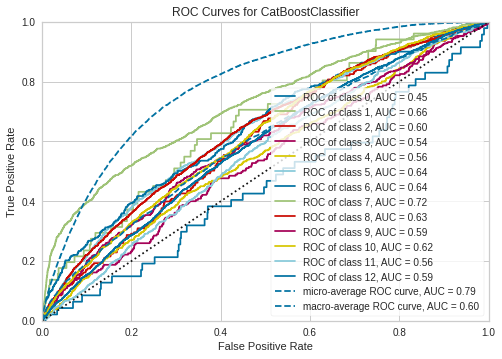

In [ ]:
plot_model(tuned_ctb)

In [ ]:
predicted_df = predict_model(tuned_ctb)
predicted_df

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.2786,0.6187,0.1265,0.242,0.2363,0.1103,0.1153


,0,1,2,3,4,5,6,7,8,9,sentiment,Label,Score
0,0.0,0.014804,0.000581,0.00000,0.000000,0.000019,0.022224,0.000000,0.000000,0.000000,sadness,worry,0.3199
1,0.0,0.006410,0.001258,0.00000,0.000273,0.000000,0.000886,0.000719,0.000615,0.000086,worry,worry,0.2927
2,0.0,0.004021,0.000000,0.00000,0.000000,0.000000,0.099136,0.000000,0.000000,0.000000,worry,neutral,0.2487
3,0.0,0.009899,0.000474,0.00000,0.000000,0.000000,0.000000,0.002278,0.000139,0.001354,happiness,worry,0.2615
4,0.0,0.008982,0.088855,0.00000,0.000000,0.000000,0.000000,0.001476,0.000000,0.000000,worry,worry,0.2064
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11996,0.0,0.000000,0.000000,0.00000,0.129548,0.000000,0.000000,0.000000,0.000000,0.000000,love,neutral,0.4928
11997,0.0,0.003084,0.000000,0.00000,0.000477,0.001369,0.001352,0.000000,0.000000,0.005661,worry,sadness,0.3360
11998,0.0,0.009104,0.001772,0.00095,0.000000,0.001661,0.000000,0.000000,0.000573,0.001642,love,neutral,0.3066
11999,0.0,0.007101,0.000153,0.00000,0.000000,0.104573,0.002279,0.000000,0.000000,0.000000,sadness,neutral,0.2859


In [ ]:
# The classification report gives us the precision, recall, and f1-score for each category.
# Here we see that most categories score low on precision, with 2 scoring better on recall.
# Generally, the F1 score is low.

from sklearn.metrics import classification_report

print(classification_report(predicted_df['sentiment'], predicted_df['Label']))

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        47
     boredom       0.00      0.00      0.00        51
       empty       0.20      0.00      0.01       223
  enthusiasm       0.00      0.00      0.00       235
         fun       0.04      0.00      0.00       542
   happiness       0.24      0.17      0.20      1526
        hate       0.32      0.04      0.07       381
        love       0.40      0.32      0.35      1167
     neutral       0.30      0.53      0.38      2598
      relief       0.12      0.01      0.02       458
     sadness       0.23      0.13      0.17      1591
    surprise       0.06      0.00      0.00       635
       worry       0.26      0.43      0.32      2547

    accuracy                           0.28     12001
   macro avg       0.17      0.13      0.12     12001
weighted avg       0.24      0.28      0.24     12001



Finalize model and deploy

In [ ]:
# Train the model using 100% of the data
final_model = finalize_model(tuned_ctb)

model_filepath = os.path.join(model_path, 'emotions_2021_04_04')
# Save the model
save_model(final_model, model_name=model_filepath)

### Use-case 2: Recommender

The given dataset comes from Spotify, and records the frequency of listening to each artist for each user.

We will build a recommender system to recommend new artists to users. To achieve this, we will use NMF in conjunction with the cosine similarity score. This cosine similarity score is not covered in the notes, but is an easy to understand implementation.
> As data scientists, new techniques surface all the time. Thus, you need to get used to learning on the fly.

In [11]:
# Read dataset and set the artistname as index
dataset = pd.read_csv(data_path / 'spotify.csv')
dataset.set_index('artistname', inplace=True)

In [ ]:
# Inspect the dataset
# There are 7,341 artists with 5274 users, the intersection is the number of times
# one of the artist's song is listened by the user.
# Note that we are not constrained to processing only the English language for
# this use-case

dataset

,1,2,5,7,9,10,11,13,17,23,30,31,33,35,36,38,39,41,42,45,47,50,51,53,63,65,69,70,75,80,85,95,96,106,110,118,121,124,128,136,...,15775,15777,15779,15784,15785,15787,15790,15797,15802,15809,15817,15821,15824,15829,15830,15831,15836,15838,15845,15847,15848,15851,15855,15857,15867,15871,15872,15873,15878,15882,15888,15890,15896,15903,15905,15908,15909,15910,15912,15913
artistname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#1 Hits Now,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
'T Hof Van Commerce,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
(Hed) P.E.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...And You Will Know Us By The Trail Of Dead,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
047,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
竹内まりや,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
純音樂,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
羽泉,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Step 1: Data Preprocessing

As with all data science workflow/pipeline, the first step is always data preprocessing.

Look at the nature of this dataset and think of the use-case objective
> We are tasked to recommend artists.
>
> Recommendation deals with "people who like this tends to like that".
>
> The nature of the deliverable deals with segmentation - thus hinting that an unsupervised learning approach is more likely.
>
> There are a lot of 0 in this dataset, with a large number of columns
>> we should use sparse-matrix

Think about the potential bias of this dataset.
> Users' listening frequencies are different. Some users listen to songs all day long, some don't.
>
> Also, some users listen to many artists in a given amount of time, while others don't.
>
> As a result, we don't want our models to get influenced by these bias (objective is recommend artists that you may like, which should not be influenced by users who listens a lot).
>> We can use a transformation called the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) to such that all users have the same influence on the model.

The values in this dataset are all non-negative. Allows us to use NMF.




In [12]:
# Convert to sparse matrix else the processing will take a long time
from scipy.sparse import csr_matrix

csr_mat = csr_matrix(dataset)

In [13]:
# Run through a few entries in csr_mat to check
# that the data is correctly represented
print(csr_mat)

  (0, 1708)	100
  (1, 1235)	75
  (2, 3514)	89
  (3, 2834)	61
  (4, 535)	60
  (5, 90)	98
  (6, 2091)	63
  (6, 3894)	88
  (7, 1855)	99
  (8, 1091)	60
  (9, 57)	148
  (9, 3035)	76
  (10, 1585)	73
  (10, 1923)	86
  (10, 2249)	54
  (10, 3618)	69
  (11, 3983)	59
  (12, 4412)	62
  (13, 672)	60
  (13, 2430)	54
  (14, 1883)	140
  (15, 350)	53
  (16, 576)	101
  (16, 1923)	55
  (17, 62)	71
  :	:
  (7323, 2656)	58
  (7324, 4745)	68
  (7325, 2142)	69
  (7326, 2696)	142
  (7327, 815)	59
  (7327, 1094)	59
  (7327, 2188)	53
  (7327, 2393)	117
  (7327, 2656)	88
  (7327, 3075)	55
  (7327, 5154)	67
  (7328, 23)	89
  (7329, 23)	165
  (7330, 1682)	73
  (7331, 3526)	59
  (7332, 915)	111
  (7333, 5210)	95
  (7334, 2817)	94
  (7334, 5210)	177
  (7335, 5210)	134
  (7336, 1403)	127
  (7337, 3298)	102
  (7338, 5210)	77
  (7339, 5210)	100
  (7340, 5210)	53


Create a pipeline with max abs scaler, followed by NMF with 20 components, then a normalizer.

The normalizer is required to calculate cosine similarity (see below for explanation).

Fit and transform the data.

In [27]:
from sklearn.preprocessing import MaxAbsScaler, Normalizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline

# Create an instance of MaxAbsScaler
mas = MaxAbsScaler()

# Create an instance of NMF
nmf = NMF(n_components=20)

# Create an instance of normalizer
nml = Normalizer()

# Create a pipeline
pipeline = make_pipeline(mas, nmf, nml)

In [28]:
# Fit and transform the data
nmf_features = pipeline.fit_transform(csr_mat)

#### Step 2: Recommendation

First, read the NMF features for each artist.

Recap: 
> each artist is represented by an NMF feature which is a weighted sum of NMF components.
>
> each NMF component is a weighted combination of the normalized listening frequency by each of the spotify users.
>> Thus the pattern of listening frequency across the entire user sample (12,333 users), represented as 20 components, segmentize artists into various themes.

In [29]:
df = pd.DataFrame(nmf_features, index=dataset.index)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
artistname,,,,,,,,,,,,,,,,,,,,
#1 Hits Now,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
'T Hof Van Commerce,0.120369,0.959617,0.244826,0.027198,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.062989,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
(Hed) P.E.,0.000000,0.002467,0.000000,0.696941,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.717124,0.0,0.000000,0.000000,0.0,0.000000
...And You Will Know Us By The Trail Of Dead,0.000000,0.106335,0.000000,0.421224,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.148092,0.531127,0.000000,0.111445,0.0,0.295607,0.000000,0.0,0.638305
047,0.000000,0.000000,0.000000,0.000000,0.519925,0.313739,0.000000,0.0,0.201024,0.0,0.000000,0.000000,0.750866,0.000000,0.000000,0.0,0.000000,0.164427,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
竹内まりや,0.000000,0.058650,0.000000,0.528487,0.000000,0.000000,0.130526,0.0,0.000000,0.0,0.000000,0.000000,0.244497,0.230665,0.721898,0.0,0.000000,0.000000,0.0,0.257106
純音樂,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.092266,0.0,0.000000,0.0,0.018107,0.256241,0.129612,0.000000,0.169196,0.0,0.029623,0.937654,0.0,0.000000
羽泉,0.000000,0.000000,0.000000,0.000000,0.303049,0.000000,0.436103,0.0,0.000000,0.0,0.792392,0.000000,0.000000,0.000000,0.044745,0.0,0.000000,0.296796,0.0,0.000000


#### Step 3: Using the recommender system

We will use the cosine similarity score to filter the most similar artist.

**What is cosine similarity?**
![Cosine Similarity](https://lh3.googleusercontent.com/pw/ACtC-3cxROIwgGo3dAw3nbCsMvzah445HiRn1HygejcargAsCf3fpYBfzwUr17-u5xga9u3Oxqxv_PvVlkWscPdUioMnhn9A2d1Cu7YyzSBcXDoGjHTvhwuUlb7WCAttKb-1TnocAKhLtHjZZtH65v8FKrFY-g=w1000-h646-no?authuser=0)

Suppose we have performed a normalized NMF with only 2 components (i.e. feature 1 and 2).

Each sample in the dataset will be represented by different combinations of values for feature 1 and 2.
> Suppose sample 1 (red line) and sample 2 (blue line) plots as above.
> Notice that they do not lie on the same line and thus there is an angle in-between them. This angle is measured as the degree cosine.

**Interpreting cosine similarity**
If both samples are very similar to each other, then their feature 1 and 2 values will be very close to each other.
> If they are exactly the same, then they will coincide and lie on the same line. In this case, the angle will be 0 and cosine similarity will be 1.
>> see the top diagram on the right.
>
> If they are totally not related, the angle is 90 degrees, and we call this characteristic 'orthogonal'. In this case, the cosine similarity will be 0.
>> see the middle diagram on the right.
>
> If they are completely opposite, the angle is 180 degrees. In this case, the cosine similarity will be -1.
>> see the bottom diagram on the right.

Cosine similarity can be calculated using the .dot method of numpy or pandas.

In [ ]:
from sklearn.preprocessing import normalize
# Example

data = np.array([
    [1, 2, 3, 4],
    [1, 2, 3, 4],
    [-2, 1, -4, 3],
    [-1, -2, -3, -4],
    [0, 1, 0, 5]
])

df_norm = pd.DataFrame(normalize(data), columns=['feature1', 'feature2', 'feature3', 'feature4'])

In [ ]:
# Sample 1 and 2 are the same values.
# Sample 3 is orthogonal to sample 1 and 2
# Sample 4 is in the opposite direction of sample 1 and 2
# Sample 5 is different from all other samples
df_norm

,feature1,feature2,feature3,feature4
0,0.182574,0.365148,0.547723,0.730297
1,0.182574,0.365148,0.547723,0.730297
2,-0.365148,0.182574,-0.730297,0.547723
3,-0.182574,-0.365148,-0.547723,-0.730297
4,0.000000,0.196116,0.000000,0.980581


In [ ]:
# We take the first sample and call it point_1.
point_1 = df_norm.loc[0]
point_1

feature1    0.182574
feature2    0.365148
feature3    0.547723
feature4    0.730297
Name: 0, dtype: float64

In [ ]:
# Using the .dot method of pandas, we compute
# the dot product between sample 1 and all other samples
df_norm.dot(point_1)

0    1.000000
1    1.000000
2    0.000000
3   -1.000000
4    0.787726
dtype: float64

Check that the cosine similarity between sample 1 and 2 are 1. 

With sample 3, the cosine similarity is 0.

With sample 4, the cosine similarity is -1.

Coming back to the assessment.

Use the cosine similarity that you have learnt to find the best recommendations for the following 2 artists.

In [39]:
# People who listen to the following artists, who else
# will they like to listen to?
artist_name_1 = '王力宏'
artist_name_2 = 'Imagine Dragons'
artist_name_3 = 'فريد الاطرش'

In [40]:
# What is the listening profile of this artist learned by NMF?
artist = df.loc[artist_name_3]
artist

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.036477
11    0.000000
12    0.000000
13    0.000000
14    0.000000
15    0.000000
16    0.000000
17    0.999334
18    0.000000
19    0.000000
Name: فريد الاطرش, dtype: float64

In [41]:
# Who are the artists with similiar listening profiles? 
# ## Compute the cosine similarity score against the NMF results for all artists
similarities = df.dot(artist)
similarities

artistname
#1 Hits Now                                     0.000000
'T Hof Van Commerce                             0.000000
(Hed) P.E.                                      0.000000
...And You Will Know Us By The Trail Of Dead    0.000000
047                                             0.164318
                                                  ...   
竹内まりや                                           0.000000
純音樂                                             0.937691
羽泉                                              0.325503
陳奕迅                                             0.325503
陶喆                                              0.325503
Length: 7341, dtype: float64

In [42]:
# Who are the closest artists? 
# ## Use nlargest() to filter the top n scores
similarities.nlargest(10)

artistname
فريد الاطرش               1.000000
Everclear                 0.999989
Alesana                   0.999334
Becoming The Archetype    0.999334
Campo De Almas.           0.999334
Eartha Kitt               0.999334
Helena Paparizou          0.999334
Jim Johnston              0.999334
Libido                    0.999334
Mohammed Rafi             0.999334
dtype: float64

Class Exercise: For each of the following artists, find the top 5 closest recommendation.



In [ ]:
artists = ['周杰倫', 'فريد الاطرش', 'Will Smith', 'Macy Gray', 'Green Day']

Discussion: How do you test if a user is willing to try new listening profiles?
> How would you organize the logic of your recommendation? (Nothing to do with ML algorithms!)
>
> How do you measure the difference in willingness?
>
> How would you recommend accordingly? 

### Here's the codes to install rapids.ai in case you want to execute the long-running codes in GPU.

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell first.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.
# Don't run the next cell until you see the session restarts.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  
# Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# Installing RAPIDS
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
# Install the additional packages
!pip3 install pycaret[full]
!pip3 install pandas-profiling
!pip3 install shap
!pip3 install pyarrow

# install lightgbm GPU
!pip3 install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"